# Homework 3: Scraping and Regression



## Part 1 Data Acquisition


Check out the robots.txt file for HN to make sure you're allowed to scrape it for stories.

User-Agent: *

Crawl-delay: 30

Disallow: /collapse?

Disallow: /context?

Disallow: /flag?

Disallow: /login

Disallow: /logout

Disallow: /r?

Disallow: /reply?

Disallow: /submitlink?

Disallow: /vote?

Disallow: /x?

In [65]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import urllib.request
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#Grab the first 5 pages of stories from hackernews
#/?= for pages
url= "https://news.ycombinator.com/?p="

#grab the following data
#Rank (the number of the story on hacker news)
ranks = []
#Length of the title
LengthOfTitle = []
#Age, in hours (note, some stories are days or minutes old. You should be able to handle this)
agesInHour = []
#Points (note, some stories don't have scores! Give them 0 points)
points = []
#Number of comments (again, some stories have no comments. Mark them 0)
numOfComments = []




#Grab the first 5 pages
for page in range(5):
    url1= url + str(page+1)
    with urllib.request.urlopen (url) as response:
        html = response.read().decode("utf-8")
    with open ("story" + str(page+1) + ".html", "w") as new_file:
        new_file.write(html)
    soup = BeautifulSoup(html, 'html.parser')

    #Find rank in story
    for post in soup.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.','')
        ranks.append(int(rank))

    # Find length of title
    for title in soup.find_all(class_="titleline"):
        LengthOfTitle.append(len(title.text))

    # Calculate age in hours
    for age in soup.find_all(class_="age"):
        ageString = str(age.text)
        ageString = ageString.removesuffix(" hours ago")
        ageString = ageString.removesuffix(" hour ago")
        if " day ago" in ageString:
            agesInHour.append(24)
        elif " days ago" in ageString:
            ageString = ageString.replace(" days ago", "")
            ageInteger = int(ageString)
            agesInHour.append(24 * ageInteger)
        elif " minute ago" in ageString:
            agesInHour.append(0)
        elif " minutes ago" in ageString:
            agesInHour.append(0)
        else:
            agesInHour.append(int(ageString))

    # Find points and number of comments
    for subtext in soup.find_all(class_="subtext" ):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            point = int(re.search(r'\d+', str(score.text)).group())

        for hyperlink in subtext.find_all("a"):
            if hyperlink.text.endswith("comments"):
                aString = str(hyperlink.text)
                comments = int(re.search(r'\d+', aString).group())
        numOfComments.append(int(comments))
        points.append(int(point))
        
    #crawl delay
    time.sleep(3) 

#Once you have all your data, create a dataframe to store it
dataframe = pd.DataFrame({
    "rank": ranks, 
    "title_length": LengthOfTitle, 
    "age_in_hours": agesInHour, 
    "points": points, 
    "comment_count": numOfComments})
print(dataframe)

#save a CSV file so you don't have to hit the server repeatedly to reload the data
dataframe.to_csv('stories.csv', index=False)

   

     rank  title_length  age_in_hours  points  comment_count
0       1            75             6     220            112
1       2            54             6     154             71
2       3            80             0       3              0
3       4            36            13     371             58
4       5            24             9     163             23
..    ...           ...           ...     ...            ...
145    26            49            14      67             45
146    27            59            17     256             70
147    28            59            13     132             95
148    29            79            18     191             86
149    30            69            15      82             21

[150 rows x 5 columns]


## Part 2 Regression


We're interested in how to get a high-ranking story on Hackernews. Explore several possible least squares regressions to predict a story's rank based on the other variables (or combinations thereof). Include at least 3 different regressions. Compare/contrast them. Which is the most useful. Are there linear relationships between any of the variables? How about other relationships like inverse linear (1/x)?



 It seems like the lower the points the lower the rank is(inverse linear). There is also a trend that longer the title the higher the rank. Also, it seems like the older the story is the higher the rank tends to be. Out of the regression graphs Age in hours vs rank trend is the most steep while points vs rank is the least. Rank is only positively correlated with title length, age, and number of comments. The most useful would be seeing the stories age, since it seems like that factor correlates the most to rank. The older the post is the higher the rank, and the inverse is true for the opposite, the newer the post is the lower the rank will be. 


rank             0
title_length     0
age_in_hours     0
points           0
comment_count    0
dtype: int64
             rank  title_length  age_in_hours      points  comment_count
count  150.000000    150.000000    150.000000  150.000000     150.000000
mean    15.500000     62.366667     10.100000  126.133333      53.033333
std      8.684438     16.342565      5.065676   93.704066      45.958460
min      1.000000     24.000000      0.000000    3.000000       0.000000
25%      8.000000     51.000000      6.000000   53.000000      14.000000
50%     15.500000     59.500000     10.000000  126.500000      46.500000
75%     23.000000     75.000000     14.000000  163.000000      79.000000
max     30.000000     93.000000     18.000000  371.000000     219.000000
Model 1 Summary
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:      

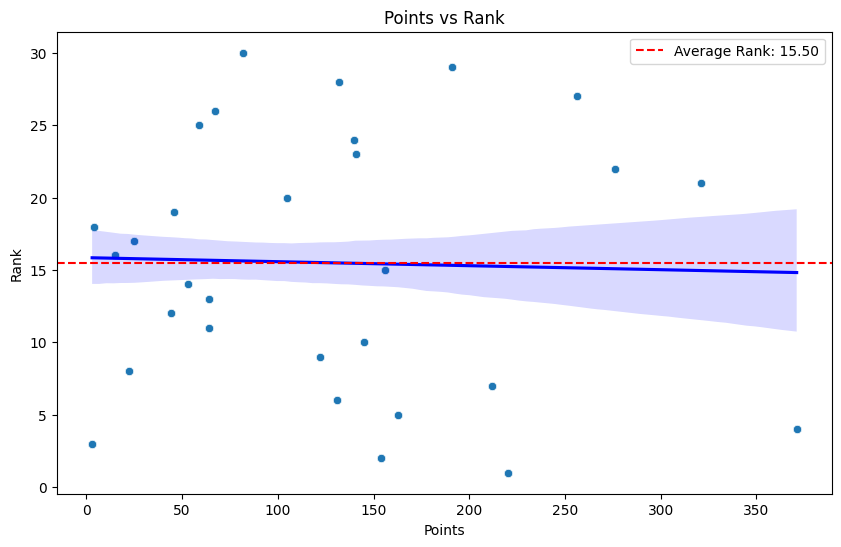

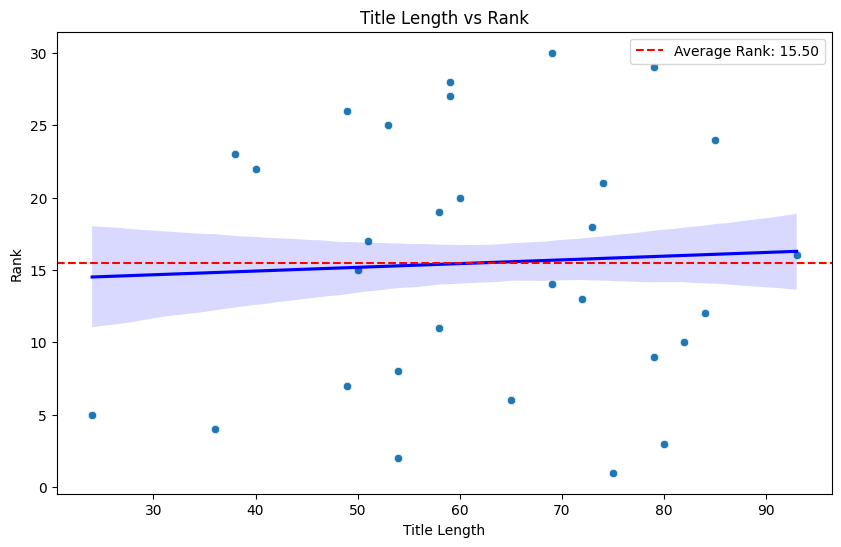

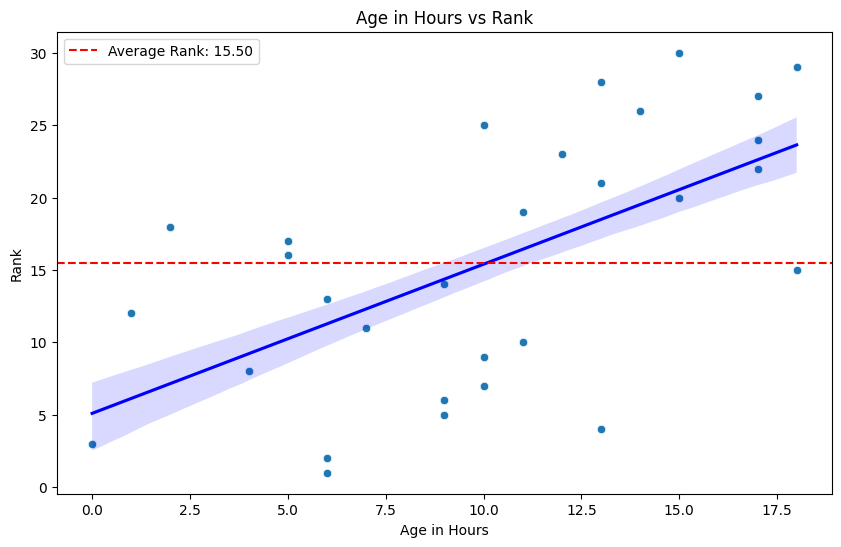

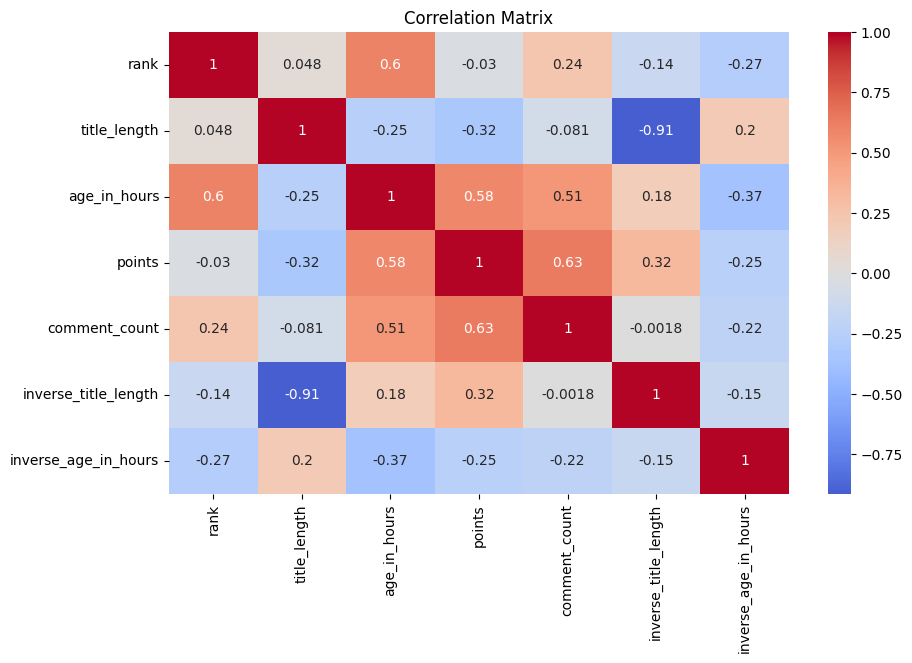

In [66]:
# Load the data
data = pd.read_csv('stories.csv')
data.head()

# Check for missing values
print(data.isnull().sum())

# Summary statistics
print(data.describe())

data['inverse_title_length'] = 1 / data['title_length']
# Avoid division by zero
data['inverse_age_in_hours'] = 1 / data['age_in_hours'].replace(0, 0.001)  


# Simple Linear Regression: Rank ~ Points
X1 = data[['points']]
y = data['rank']
X1 = sm.add_constant(X1)  # Add a constant term for the intercept
model1 = sm.OLS(y, X1).fit()

# Multiple Linear Regression: Rank ~ Points + Title Length + Age in Hours
X2 = data[['points', 'title_length', 'age_in_hours']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()

# Multiple Linear Regression with Inverse Features
X3 = data[['points', 'title_length', 'age_in_hours', 'inverse_title_length', 'inverse_age_in_hours']]
X3 = sm.add_constant(X3)
model3 = sm.OLS(y, X3).fit()


print("Model 1 Summary")
print(model1.summary())

print("\nModel 2 Summary")
print(model2.summary())

print("\nModel 3 Summary")
print(model3.summary())

# Scatter plot of Points vs. Rank with an average line and a regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='points', y='rank', data=data)
sns.regplot(x='points', y='rank', data=data, scatter=False, color='blue')
plt.axhline(y=data['rank'].mean(), color='r', linestyle='--', label=f'Average Rank: {data["rank"].mean():.2f}')
plt.title('Points vs Rank')
plt.xlabel('Points')
plt.ylabel('Rank')
plt.legend()
plt.show()

# Scatter plot of Title Length vs. Rank with an average line and a regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='rank', data=data)
sns.regplot(x='title_length', y='rank', data=data, scatter=False, color='blue')
plt.axhline(y=data['rank'].mean(), color='r', linestyle='--', label=f'Average Rank: {data["rank"].mean():.2f}')
plt.title('Title Length vs Rank')
plt.xlabel('Title Length')
plt.ylabel('Rank')
plt.legend()
plt.show()

# Scatter plot of Age in Hours vs. Rank with an average line and a regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age_in_hours', y='rank', data=data)
sns.regplot(x='age_in_hours', y='rank', data=data, scatter=False, color='blue')
plt.axhline(y=data['rank'].mean(), color='r', linestyle='--', label=f'Average Rank: {data["rank"].mean():.2f}')
plt.title('Age in Hours vs Rank')
plt.xlabel('Age in Hours')
plt.ylabel('Rank')
plt.legend()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Part 3 Classification

As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page. Use logistic regression to attempt to classify whether or not an article will be on the front page, given the other (non-rank) variables. Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for not), for example.

Include plots showing your regression (for the functions of 1 or 2 variables). 





What do your regressions tell you about making the front page?

It looks like newer posts have a higher chance of making it to the front page especially those with a lot more comments. It also looks like the amount of points could play in a small factor.  I am not seeing a correlation for title length. 

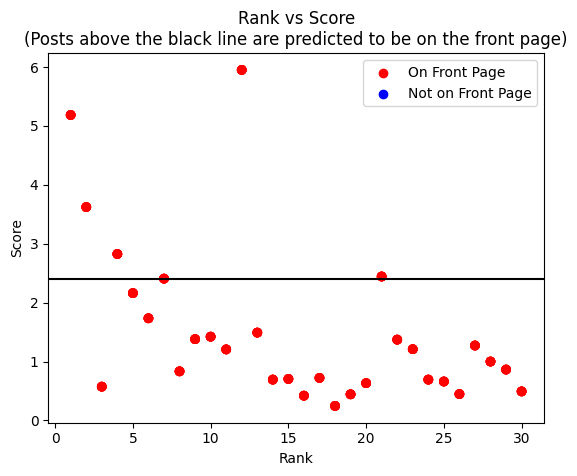

         Current function value: 0.000000
         Iterations: 35


/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara

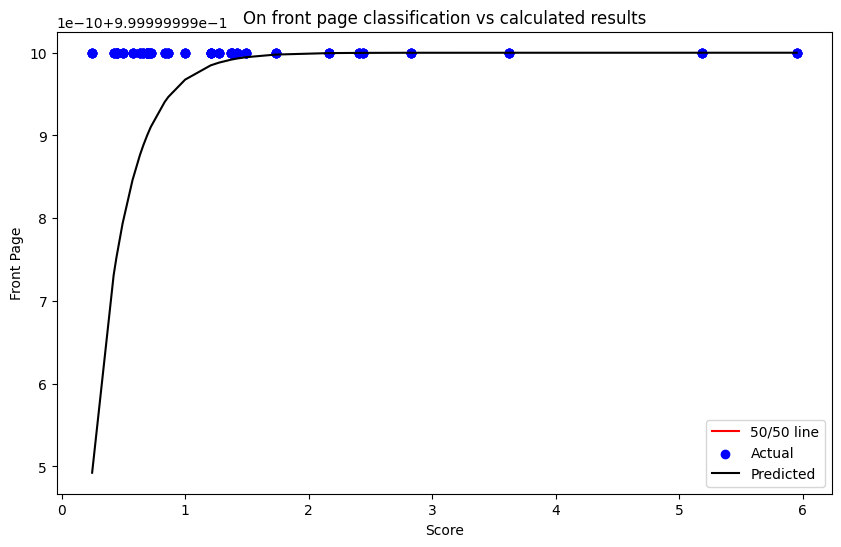

                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                     inf
Time:                        00:50:21   Log-Likelihood:            -1.2331e-08
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4987   2.25e+04      0.001      0.999   -4.41e+04    4.41e+04
score          3.6489   3.92e+04   9.31e-05      1.000   -7.68e+04    7.68e+04

Complete Separation: The results show that there is

/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/ryliebyers/CS6017/HW3/ScrapingAndRegression/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSepara

In [67]:
first_page_threshold_rank = 30

dataframe['Front Page'] = np.where(dataframe['rank'] <= first_page_threshold_rank, 1, 0)

dataframe['score'] = (dataframe['points'] - 1) / (dataframe['age_in_hours'] + 2) ** 1.8

# Sort DataFrame by 'Score' in descending order
dataframe = dataframe.sort_values(by='score', ascending=False)

# Initialize 'Predicted Front Page' column with 0 for all rows
dataframe['Predicted Front Page'] = 0

# Assign 1 to top 30 rows
dataframe.loc[:first_page_threshold_rank - 1,
       'Predicted Front Page'] = 1
colors = ['blue', 'red']
front_page_colors = [colors[fp] for fp in dataframe['Front Page']]

plt.scatter(dataframe['rank'], dataframe['score'], c=front_page_colors)
plt.axhline(y=dataframe.iloc[first_page_threshold_rank - 1]
            ['score'], color='black')
plt.xlabel('Rank')
plt.ylabel('Score')

# Set the title with different font sizes
plt.title('Rank vs Score\n(Posts above the black line are predicted to be on the front page)',
          fontsize=12)

# Add legends
plt.scatter([], [], color='red', label='On Front Page')
plt.scatter([], [], color='blue', label='Not on Front Page')
plt.legend()

plt.show()



X = dataframe[['score']]
y = dataframe['Front Page']

# Add constant term to X
X = sm.add_constant(X)

# Perform logistic regression
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Predict the probabilities
y_pred_proba = logit_result.predict(X)

# Find the x value when y >= 0.5
x_half_upper = X[y_pred_proba >= 0.5]['score'].min()

# Find the x value when y <= 0.5
x_half_lower = X[y_pred_proba <= 0.5]['score'].max()

x_half = (x_half_upper + x_half_lower)/2

plt.figure(figsize=(10, 6))

# Adding a red line where x = half_x
plt.axvline(x=x_half, color='red', label='50/50 line')

# Plot the logistic regression curve
plt.scatter(dataframe['score'], dataframe['Front Page'], color='blue', label='Actual')
plt.plot(dataframe['score'], y_pred_proba, color='black', label='Predicted')
plt.xlabel('Score')
plt.ylabel('Front Page')
plt.title('On front page classification vs calculated results')
plt.legend()
plt.show()

print(logit_result.summary())

